In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
from torch.utils.data import random_split, DataLoader


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:

# Transform definition to convert images to tensors in pytorch
# The series of transformations is given as an order of steps in a list

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [3]:
# Download the dataset
mnist_data_train = torchvision.datasets.MNIST(root="./mnist", train = True, transform = transform, download = True)

# Load the dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = mnist_data_train, batch_size = batch_size, shuffle = True)

Displaying the first image in the training set...


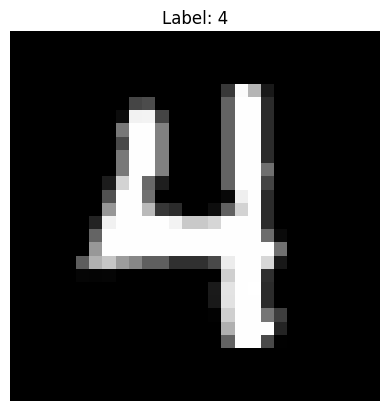

In [4]:
import matplotlib.pyplot as plt

def show_image(image, label):
    # Remove the channel dimension (1, 28, 28) -> (28, 28)
    image = image.squeeze()  
    plt.imshow(image, cmap='gray')
    
    plt.title(f"Label: {label}")
     # Turn off axis labels for better visualization
    plt.axis('off') 
    plt.show()

# Example: Display the first image from the train_loader
for images, labels in train_loader:
    print("Displaying the first image in the training set...")
    show_image(images[0], labels[0].item())
    break


In [5]:
# Download the test dataset
test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

# Split the test dataset into validation and test sets; split 50-50
valid_size = len(test_dataset) // 2 
test_size = len(test_dataset) - valid_size
valid_dataset, test_dataset = random_split(test_dataset, [valid_size, test_size])

# Create DataLoaders for validation and test sets
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Example: Inspect the number of samples in each split
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Validation set size: 5000
Test set size: 5000


## Model Building

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x
        

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [8]:
from torchsummary import summary
summary(model, (1, 28, 28))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [9]:
# Training

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for image_batch, label_batch in train_loader:
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        
        loss = criterion(outputs, label_batch)
        
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    print(f"Epoch: {epoch+1}/{num_epochs}   Train Loss: {running_loss/len(train_loader):.4f}\n")
        

Epoch: 1/10   Train Loss: 0.5671

Epoch: 2/10   Train Loss: 0.2631

Epoch: 3/10   Train Loss: 0.2210

Epoch: 4/10   Train Loss: 0.1950

Epoch: 5/10   Train Loss: 0.1710

Epoch: 6/10   Train Loss: 0.1647

Epoch: 7/10   Train Loss: 0.1521

Epoch: 8/10   Train Loss: 0.1500

Epoch: 9/10   Train Loss: 0.1439

Epoch: 10/10   Train Loss: 0.1365



In [11]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        for label in labels:
            all_labels.append(label)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for predict in predicted:
            all_preds.append(predict)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
print(f"Valid Accuracy: {100 * correct / total:.2f}%")

Valid Accuracy: 98.82%


## Data Augmentation

In [23]:
# Define data augmentation transforms
augmented_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(15),          # Rotate images by up to 15 degrees
     torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Translate up to 10%
     torchvision.transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip
     torchvision.transforms.ToTensor(),                  # Convert to tensor
     torchvision.transforms.Normalize((0.5,), (0.5,))    # Normalize to range [-1, 1]
])

In [24]:
# Download the dataset
mnist_augmented_train = torchvision.datasets.MNIST(root="./mnist", train = True, transform = augmented_transforms, download = True)

In [37]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import random

# Select a subset of the augmented dataset
num_augmented_samples = 50000  # Number of augmented samples to add
all_indices = list(range(len(mnist_augmented_train)))
selected_indices = random.sample(all_indices, num_augmented_samples)
augmented_subset = Subset(mnist_augmented_train, selected_indices)

# Combine original and selected augmented datasets
combined_train_dataset = ConcatDataset([mnist_data_train, augmented_subset])

train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)


In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x
        

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [40]:
# Training

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for image_batch, label_batch in train_loader:
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        outputs = model(image_batch)
        
        loss = criterion(outputs, label_batch)
        
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    print(f"Epoch: {epoch+1}/{num_epochs}   Train Loss: {running_loss/len(train_loader):.4f}\n")
        

Epoch: 1/10   Train Loss: 0.8983

Epoch: 2/10   Train Loss: 0.6066

Epoch: 3/10   Train Loss: 0.5468

Epoch: 4/10   Train Loss: 0.5142

Epoch: 5/10   Train Loss: 0.4894

Epoch: 6/10   Train Loss: 0.4766

Epoch: 7/10   Train Loss: 0.4695

Epoch: 8/10   Train Loss: 0.4574

Epoch: 9/10   Train Loss: 0.4473

Epoch: 10/10   Train Loss: 0.4424



In [41]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        for label in labels:
            all_labels.append(label)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for predict in predicted:
            all_preds.append(predict)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
print(f"Valid Accuracy: {100 * correct / total:.2f}%")

Valid Accuracy: 98.46%


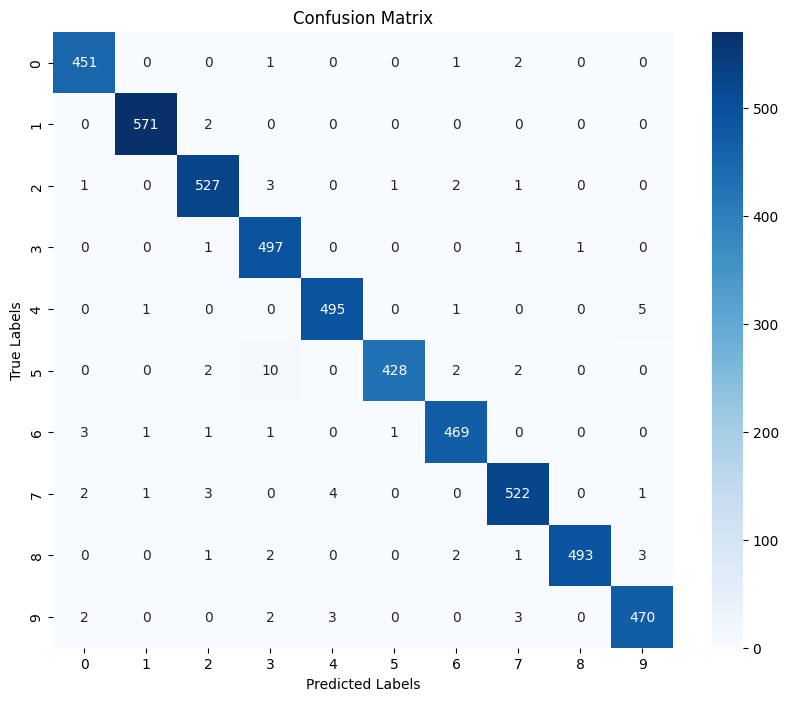

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


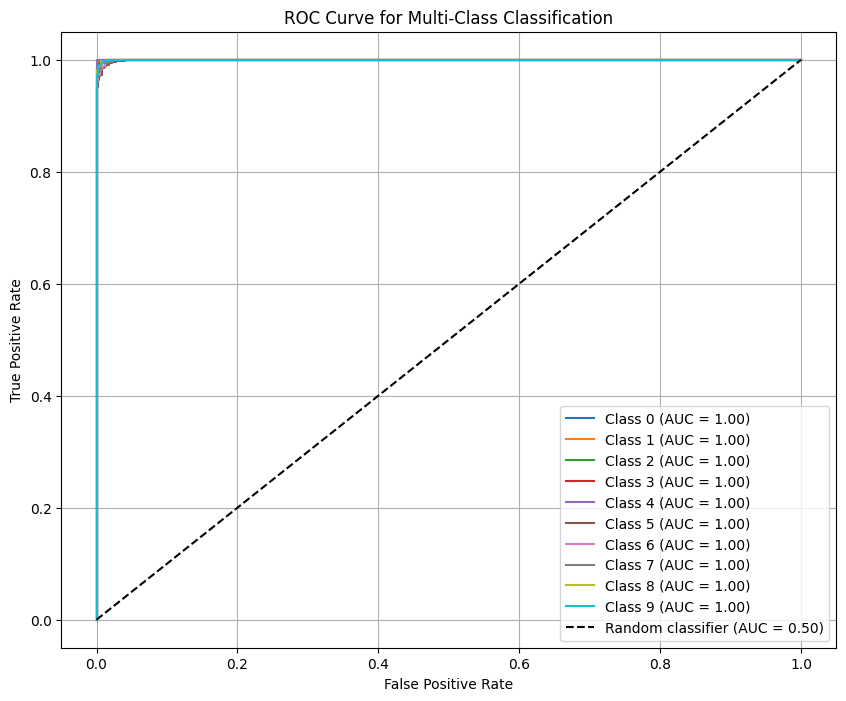

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import numpy as np
from sklearn.preprocessing import label_binarize

# Initialize containers for all labels and predictions
all_labels = []
all_outputs = []

# Make sure model is in evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs (raw scores before applying softmax)
        outputs = model(images)
        
        # Apply softmax to get probabilities
        outputs = torch.softmax(outputs, dim=1).detach().cpu().numpy()

        # Collect all outputs and labels
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs)

# Convert lists to numpy arrays
all_labels = np.concatenate(all_labels)
all_outputs = np.concatenate(all_outputs)

# Binarize the labels for multi-class ROC curve
n_classes = all_outputs.shape[1]
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plotting the diagonal line (random classifier line)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.50)')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [44]:
import plotly.graph_objects as go

# Create an empty list to store the ROC curve traces
roc_traces = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Create a plotly trace for each class
    trace = go.Scatter(
        x=fpr, y=tpr, mode='lines', name=f'Class {i} (AUC = {roc_auc:.2f})'
    )
    roc_traces.append(trace)

# Plotting the diagonal line (random classifier line)
random_line = go.Scatter(
    x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random classifier (AUC = 0.50)'
)

# Combine the traces
roc_traces.append(random_line)

# Create layout
layout = go.Layout(
    title="ROC Curve for Multi-Class Classification",
    xaxis=dict(title="False Positive Rate"),
    yaxis=dict(title="True Positive Rate"),
    showlegend=True
)

# Create the figure with all traces and layout
fig = go.Figure(data=roc_traces, layout=layout)

# Show the plot
fig.show()

In [45]:
import torch.nn.functional as F

log_loss = 0.0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        log_loss += loss.item()

log_loss /= len(test_loader)
print(f"Log-Loss: {log_loss:.4f}")


Log-Loss: 0.0588


In [46]:
def top_k_accuracy(outputs, labels, k=5):
    _, top_k_preds = torch.topk(outputs, k, dim=1)
    correct = top_k_preds.eq(labels.view(-1, 1).expand_as(top_k_preds))
    return correct.sum().item() / labels.size(0)

top_k_acc = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        top_k_acc += top_k_accuracy(outputs, labels, k=5)

top_k_acc /= len(test_loader)
print(f"Top-5 Accuracy: {top_k_acc:.2f}")


Top-5 Accuracy: 1.00
